In [1]:
import sys
sys.path.append('../../')

In [26]:
#from SynRBL.SynChemImputer.functional_group_checker import FunctionalGroupChecker
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
class UnstableMol:
    def __init__(self):
        
        pass

    @staticmethod
    def functional_group_check(mol):
        if FunctionalGroupChecker.check_vicinal_diol(mol):
            return 'vicinal_diol'
        elif FunctionalGroupChecker.check_hemiacetal(mol):
            return 'hemiacetal'
        elif FunctionalGroupChecker.check_carbonate(mol):
            return 'carbonate'
        else:
            return None

    @staticmethod
    def standardize_mol(mol):
        # standardize enol
        te = rdMolStandardize.TautomerEnumerator() # idem
        mol = te.Canonicalize(mol)

        # standardize other group
        smiles = Chem.Mol
        return mol
        # functional_group = UnstableMol.functional_group_check(smiles)
        # print(functional_group)
        # if functional_group == 'vicinal_diol':
        #     smiles = smiles.replace('OCO', 'C=O')
        #     return Chem.MolFromSmiles(smiles)
        # elif functional_group == 'hemiacetal':
        #     smiles = smiles.replace('COCO', 'CO.C=O')
        #     return Chem.MolFromSmiles(smiles)
        # elif functional_group == 'carbonate':
        #     smiles = smiles.replace('COC(=O)O', 'CO.OC(=O)O').replace('OC(=O)OC', 'COC(=O)O.OC')
        #     return Chem.MolFromSmiles(smiles)
        # else:
        #     return None


In [ ]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

class MolStandardizer:
    def __init__(self):
        pass

    @staticmethod
    def functional_group_check(mol):
        # add your functional group check here
        if FunctionalGroupChecker.check_vicinal_diol(mol):
            return 'vicinal_diol'
        elif FunctionalGroupChecker.check_hemiacetal(mol):
            return 'hemiacetal'
        elif FunctionalGroupChecker.check_carbonate(mol):
            return 'carbonate'
        else:
            return None

    @staticmethod
    def standardize_mol(mol):
        try:
            # Standardize tautomers
            enumerator = rdMolStandardize.TautomerEnumerator()
            standardized_mol = enumerator.Canonicalize(mol)

            # Convert to SMILES for further processing
            smiles = Chem.MolToSmiles(standardized_mol)
            functional_group = UnstableMol.functional_group_check(Chem.MolFromSmiles(smiles))

            # Apply specific transformations based on functional groups
            if functional_group == 'vicinal_diol':
                smiles = smiles.replace('OCO', 'C=O')
            elif functional_group == 'hemiacetal':
                smiles = smiles.replace('COCO', 'CO.C=O')
            elif functional_group == 'carbonate':
                smiles = smiles.replace('COC(=O)O', 'CO.OC(=O)O').replace('OC(=O)OC', 'COC(=O)O.OC')

            # Convert back to RDKit Mol object
            return Chem.MolFromSmiles(smiles)
        except Exception as e:
            #print(f"An error occurred: {e}")
            return mol




In [72]:
from SynRBL.SynChemImputer.functional_group_checker import FunctionalGroupChecker
from rdkit import Chem

class PeroxidGroupImputer:
    def __init__(self) -> None:
        pass
    
    @staticmethod
    def check_peroxide(smiles: str) -> bool:
        """
        Check for the presence of a peroxide substructure in a molecule.
        """
        peroxide_pattern = Chem.MolFromSmarts('OO')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(peroxide_pattern) if mol and not PeroxidGroupImputer.check_peracid(smiles) else False

    @staticmethod
    def check_peracid(smiles: str) -> bool:
        """
        Check for the presence of a peracid substructure in a molecule.
        """
        peracid_pattern = Chem.MolFromSmarts('C(OO)=O')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(peracid_pattern) if mol else False
    
    @staticmethod
    def impute_peroxide(reactant_smiles: str, product_smiles: str) -> tuple:
        """
        Impute a peroxide functional group in the reactant SMILES string and update the product SMILES accordingly.
        """
        updated = False
        reactant_components = reactant_smiles.split('.')
        for i, smiles in enumerate(reactant_components):
            if PeroxidGroupImputer.check_peroxide(smiles):
                updated_smiles = smiles.replace('OO', 'O.O')
                updated = True

        if updated:
            print(product_smiles)
            updated_product_smiles = product_smiles + '.' + Chem.CanonSmiles(updated_smiles)
            return reactant_smiles, updated_product_smiles
        else:
            return reactant_smiles, product_smiles
    
    @staticmethod
    def impute_peracid(reactant_smiles: str, product_smiles: str) -> tuple:
        """
        Impute a peracid functional group in the reactant SMILES string and update the product SMILES accordingly.
        """
        updated = False
        reactant_components = reactant_smiles.split('.')
        for i, smiles in enumerate(reactant_components):
            if PeroxidGroupImputer.check_peracid(smiles):
                updated_smiles = Chem.CanonSmiles(smiles.replace('O=C(OO)', 'O=C(O)').replace('C(=O)OO', 'C(=O)O'))
                updated = True

        if updated:
            if updated_smiles not in product_smiles.split('.'):
                updated_product_smiles = product_smiles + '.' + Chem.CanonSmiles(updated_smiles)
                return reactant_smiles, updated_product_smiles
        else:
            return reactant_smiles, product_smiles
    
    def fix(self, reactions_dict, rsmi_col, symbol='>>'):
        reactans, products = reactions_dict[rsmi_col].split(symbol)
        if PeroxidGroupImputer.check_peroxide(reactans):
            reactans, products = PeroxidGroupImputer.impute_peroxide(reactans, products)
        elif PeroxidGroupImputer.check_peracid(reactans):
            reactans, products = PeroxidGroupImputer.impute_peracid(reactans, products)
        else:
            pass
        reactions_dict[rsmi_col] = symbol.join([reactans, products])
        return reactions_dict

In [77]:
from rdkit import Chem

class PeroxidGroupImputer:
    """A class for imputing peroxide and peracid groups in chemical reactions."""

    @staticmethod
    def check_peroxide(smiles: str) -> bool:
        """Check for the presence of a peroxide substructure in a molecule."""
        try:
            peroxide_pattern = Chem.MolFromSmarts('OO')
            mol = Chem.MolFromSmiles(smiles)
            return mol.HasSubstructMatch(peroxide_pattern) if mol and not PeroxidGroupImputer.check_peracid(smiles) else False
        except:
            return False

    @staticmethod
    def check_peracid(smiles: str) -> bool:
        """Check for the presence of a peracid substructure in a molecule."""
        try:
            peracid_pattern = Chem.MolFromSmarts('C(OO)=O')
            mol = Chem.MolFromSmiles(smiles)
            return mol.HasSubstructMatch(peracid_pattern) if mol else False
        except:
            return False

    @staticmethod
    def impute_peroxide(reactant_smiles: str, product_smiles: str) -> tuple:
        """Impute a peroxide functional group in the reactant SMILES string and update the product SMILES accordingly."""
        updated = False
        reactant_components = reactant_smiles.split('.')
        for smiles in reactant_components:
            if PeroxidGroupImputer.check_peroxide(smiles):
                updated_smiles = smiles.replace('OO', 'O.O')
                updated = True

        if updated:
            updated_product_smiles = product_smiles + '.' + Chem.CanonSmiles(updated_smiles)
            return reactant_smiles, updated_product_smiles
        else:
            return reactant_smiles, product_smiles

    @staticmethod
    def impute_peracid(reactant_smiles: str, product_smiles: str) -> tuple:
        """Impute a peracid functional group in the reactant SMILES string and update the product SMILES accordingly."""
        updated = False
        reactant_components = reactant_smiles.split('.')
        for smiles in reactant_components:
            if PeroxidGroupImputer.check_peracid(smiles):
                updated_smiles = Chem.CanonSmiles(smiles.replace('O=C(OO)', 'O=C(O)').replace('C(=O)OO', 'C(=O)O'))
                updated = True

        if updated and updated_smiles not in product_smiles.split('.'):
            updated_product_smiles = product_smiles + '.' + Chem.CanonSmiles(updated_smiles)
            return reactant_smiles, updated_product_smiles
        else:
            return reactant_smiles, product_smiles

    def fix(self, reactions_dict: dict, rsmi_col: str, symbol: str = '>>') -> dict:
        """Process and update reactions containing peroxide or peracid groups."""
        reactants, products = reactions_dict[rsmi_col].split(symbol)
        if PeroxidGroupImputer.check_peroxide(reactants):
            reactants, products = PeroxidGroupImputer.impute_peroxide(reactants, products)
        elif PeroxidGroupImputer.check_peracid(reactants):
            reactants, products = PeroxidGroupImputer.impute_peracid(reactants, products)
        reactions_dict[rsmi_col] = symbol.join([reactants, products])
        return reactions_dict


In [81]:
reactions_dict = [{'reactions': 'COOC.C>>C'}, {'reactions': 'C=C.C1=CC(=CC(=C1)Cl)C(=O)OO>>O1CC1'}]
pero_imputer = PeroxidGroupImputer()

pero_imputer.fix(reactions_dict[1], 'reactions')

{'reactions': 'C=C.C1=CC(=CC(=C1)Cl)C(=O)OO>>O1CC1.O=C(O)c1cccc(Cl)c1'}

In [82]:
pero_imputer.fix(reactions_dict[0], 'reactions')

{'reactions': 'COOC.C>>C.CO.CO'}

In [ ]:
PeroxidGroupImputer.fix()

In [63]:
test = 'CC>>CCO' 
symbol = '>>'
reactans, products = test.split(symbol)

In [64]:
reactans

'CC'

In [61]:
test.split(symbol)

['CC>>CCO']

In [52]:
Chem.CanonSmiles('O=C(OO)')

'O=COO'

In [49]:
PeroxidGroupImputer.impute_peroxide('C.CCOOCC', 'C')

C


('C.CCOOCC', 'C.CCO.CCO')

In [56]:
PeroxidGroupImputer.impute_peracid('C=C.C1=CC(=CC(=C1)Cl)C(=O)OO', 'O1CC1')

O=C(O)c1cccc(Cl)c1


In [53]:
Chem.CanonSmiles('C1=CC(=CC(=C1)Cl)C(=O)OO')

'O=C(OO)c1cccc(Cl)c1'

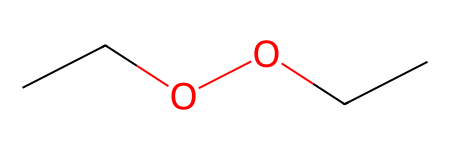

In [31]:
Chem.MolFromSmiles('CCOOCC')

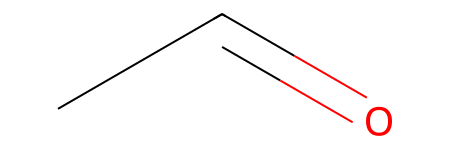

In [27]:
un_mol = UnstableMol()
un_mol.standardize_mol(Chem.MolFromSmiles('C=CO'))

In [11]:
enol = 'C=CO'

In [14]:

mol = Chem.MolFromSmiles('C=CO')
te = rdMolStandardize.TautomerEnumerator() # idem
taut_mol = te.Canonicalize(mol)
    

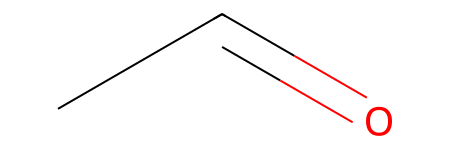

In [15]:
taut_mol

In [ ]:
smi_diol = 'OCO'
smi_enol = 'C=C(O)'
smi_hemiacetal = 'COCO'
smi_carbonate = 'COC(=O)O'

In [ ]:
from thermo.functional_groups import *
from rdkit import Chem

In [ ]:
is_alcohol(Chem.MolFromSmiles('COCO')) 

In [ ]:
Chem.MolFromSmiles('C1=CC=CC=C1O')

In [ ]:
UnstableMol.fix(smi_diol)

In [ ]:
UnstableMol.fix(smi_enol)

In [ ]:
UnstableMol.fix(smi_carbonate)

In [ ]:
from rdkit import Chem

class FunctionalGroupChecker:
    
    # 1. peroxid group
    @staticmethod
    def check_peroxide(smiles: str) -> bool:
        """
        Check for the presence of a peroxide substructure in a molecule.
        """
        peroxide_pattern = Chem.MolFromSmarts('OO')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(peroxide_pattern) if mol and not FunctionalGroupChecker.check_peracid(smiles) else False

    @staticmethod
    def check_peracid(smiles: str) -> bool:
        """
        Check for the presence of a peracid substructure in a molecule.
        """
        peracid_pattern = Chem.MolFromSmarts('C(OO)=O')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(peracid_pattern) if mol else False

    # 2. Alcohol group
    @staticmethod
    def check_alcohol(smiles: str) -> bool:
        """
        Check for the presence of an alcohol functional group in a molecule.
        """
        alcohol_pattern = Chem.MolFromSmarts('CO')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(alcohol_pattern) if mol else False
    
    @staticmethod
    def check_enol(smiles: str) -> bool:
        """
        Check for the presence of an enol functional group in a molecule.
        """
        enol_pattern = Chem.MolFromSmarts('C=C(O)')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(enol_pattern) if mol else False

    @staticmethod
    def check_phenol(smiles: str) -> bool:
        """
        Check for the presence of a phenol functional group in a molecule.
        """
        phenol_pattern = Chem.MolFromSmarts('[c]O')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(phenol_pattern) if mol else False

    @staticmethod
    def check_vicinal_diol(smiles: str) -> bool:
        """
        Check for the presence of a vicinal diol functional group in a molecule.
        """
        vicinal_diol_pattern = Chem.MolFromSmarts('OCO')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(vicinal_diol_pattern) if mol and not FunctionalGroupChecker.check_hemiacetal(smiles)  and not FunctionalGroupChecker.check_carbonate(smiles) and not FunctionalGroupChecker.check_carboxylic_acid(smiles) and not FunctionalGroupChecker.check_ester(smiles) else False

    @staticmethod
    def check_gem_diol(smiles: str) -> bool:
        """
        Check for the presence of a gem diol functional group in a molecule.
        """
        gem_diol_pattern = Chem.MolFromSmarts('OCCO')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(gem_diol_pattern) if mol else False

    @staticmethod
    def check_ether(smiles: str) -> bool:
        """
        Check for the presence of an ether functional group in a molecule.
        """
        ether_pattern = Chem.MolFromSmarts('COC')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(ether_pattern) if mol else False

    # 3. Carbonyl group
    @staticmethod
    def check_aldehyde(smiles: str) -> bool:
        """
        Check for the presence of an aldehyde functional group in a molecule.
        """
        aldehyde_pattern = Chem.MolFromSmarts('[CX3H1](=O)[#6]')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(aldehyde_pattern) if mol else False

    @staticmethod
    def check_ketone(smiles: str) -> bool:
        """
        Check for the presence of a ketone functional group in a molecule.
        """
        ketone_pattern = Chem.MolFromSmarts('[#6][CX3](=O)[#6]')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(ketone_pattern) if mol else False

    @staticmethod
    def check_acetal(smiles: str) -> bool:
        """
        Check for the presence of an acetal functional group in a molecule.
        """
        acetal_pattern = Chem.MolFromSmarts('[CX4][OX2][CX4]')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(acetal_pattern) if mol else False

    @staticmethod
    def check_hemiacetal(smiles: str) -> bool:
        """
        Check for the presence of a hemiacetal functional group in a molecule.
        """
        hemiacetal_pattern = Chem.MolFromSmarts('COCO')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(hemiacetal_pattern) if mol and not FunctionalGroupChecker.check_carbonate(smiles) and not FunctionalGroupChecker.check_carboxylic_acid(smiles) and not FunctionalGroupChecker.check_ester(smiles) else False

    # 4. Carboxylic group
    @staticmethod
    def check_carboxylic_acid(smiles: str) -> bool:
        """
        Check for the presence of a carboxylic acid functional group in a molecule.
        """
        carboxylic_acid_pattern = Chem.MolFromSmarts('C(=O)O')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(carboxylic_acid_pattern) if mol else False

    @staticmethod
    def check_ester(smiles: str) -> bool:
        """
        Check for the presence of an ester functional group in a molecule.
        """
        ester_pattern = Chem.MolFromSmarts('C(=O)OC')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(ester_pattern) if mol and not FunctionalGroupChecker.check_carbonate(smiles) else False

    @staticmethod
    def check_amide(smiles: str) -> bool:
        """
        Check for the presence of an amide functional group in a molecule.
        """
        amide_pattern = Chem.MolFromSmarts('NC=O')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(amide_pattern) if mol and not FunctionalGroupChecker.check_urea(smiles) else False
    
    @staticmethod
    def check_cyanide(smiles: str) -> bool:
        """
        Check for the presence of a cyanide functional group in a molecule.
        """
        cyanide_pattern = Chem.MolFromSmarts('[C-]#[N+]')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(cyanide_pattern) if mol else False

    @staticmethod
    def check_urea(smiles: str) -> bool:
        """
        Check for the presence of a urea functional group in a molecule.
        """
        urea_pattern = Chem.MolFromSmarts('NC(=O)N')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(urea_pattern) if mol else False

    @staticmethod
    def check_carbonate(smiles: str) -> bool:
        """
        Check for the presence of a carbonate functional group in a molecule.
        """
        carbonate_pattern = Chem.MolFromSmarts('OC(=O)O')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(carbonate_pattern) if mol else False

    # 5. Amine group
    @staticmethod
    def check_amine(smiles: str) -> bool:
        """
        Check for the presence of an amine functional group in a molecule.
        """
        amine_pattern = Chem.MolFromSmarts('CN')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(amine_pattern) if mol and not FunctionalGroupChecker.check_amide(smiles) else False
    
    @staticmethod
    def check_nitro(smiles: str) -> bool:
        """
        Check for the presence of a nitro functional group in a molecule.
        """
        nitro_pattern = Chem.MolFromSmarts('[N+](=O)[O-]')
        mol = Chem.MolFromSmiles(smiles)
        return mol.HasSubstructMatch(nitro_pattern) if mol else False


In [ ]:
Chem.MolToSmarts(Chem.MolFromSmiles('OC(=O)O'))

In [ ]:
def oxygen_group_check(smiles):
    alcohol_pattern = Chem.MolFromSmarts('CO')
    phenol_pattern = Chem.MolFromSmarts('[c]O')
    mol = Chem.MolFromSmiles(smiles)
    if mol.HasSubstructMatch(phenol_pattern):
        return 'phenol'
    elif mol.HasSubstructMatch(alcohol_pattern):
        enol_pattern = Chem.MolFromSmarts('C=C-O')
        diol_pattern = Chem.MolFromSmarts('OCO')
        amid_pattern = Chem.MolFromSmarts('NC=O')
        #acyl_pattern = [Chem.MolFromSmarts(f'C(=O){X}') for X in ['F','Cl','Br','I']]
        if mol.HasSubstructMatch(enol_pattern):
            return 'enol'
        elif mol.HasSubstructMatch(diol_pattern):
            ()
        elif mol.HasSubstructMatch(amid_pattern):
            return 'amide'
        else:
            return 'alcohol'
    else:
        return None
       

In [ ]:
def carboxylic_derivatives_check(smiles):
    mol = Chem.MolFromSmiles(smiles)
    ester_pattern = Chem.MolFromSmarts('C(=O)OC')
    acid_pattern = Chem.MolFromSmarts('C(=O)O')
    anhydride_pattern = Chem.MolFromSmarts('O=COC=O')
    if mol.HasSubstructMatch(ester_pattern):
        return 'ester'
    elif mol.HasSubstructMatch(anhydride_pattern):
        return 'anhydride'
    else:
        return 'acid'
    

In [ ]:
def COO_check(smiles):
    mol = Chem.MolFromSmiles(smiles)
    carbon_pattern = Chem.MolFromSmarts('C')
    oxygen_pattern = Chem.MolFromSmarts('O')
    if mol.HasSubstructMatch(carbon_pattern):
        return 'carbon'
    elif mol.HasSubstructMatch(oxygen_pattern):
        return 'oxygen'
    else:
        return None

In [ ]:
Chem.MolFromSmiles('C(=O)OC(=O)')

In [ ]:
Chem.CanonSmiles('C(=O)OC(=O)')

In [70]:
from SynRBL.rsmi_utils import load_database
golden = load_database('../../Data/Validation_set/golden_dataset/MCS/Final_Graph.json.gz')

In [ ]:
len(golden)

In [ ]:
data = load_database('../../Data/Validation_set/golden_dataset/mcs_based_reactions.json.gz')
len(data)

In [14]:
#from SynRBL.SynMCSImputer.SubStructure.extract_common_mcs import ExtractMCS
from SynRBL.SynUtils.data_utils import load_database, save_database

mcs_dir = '../../Data/Validation_set/golden_dataset/MCS'
condition_1 = load_database(f'{mcs_dir}/Condition_1.json.gz')
condition_2 = load_database(f'{mcs_dir}/Condition_2.json.gz')
condition_3 = load_database(f'{mcs_dir}/Condition_3.json.gz')
condition_4 = load_database(f'{mcs_dir}/Condition_4.json.gz')
condition_5 = load_database(f'{mcs_dir}/Condition_5.json.gz')



In [ ]:
mcs

In [64]:
id_mcs = [value['R-id'] for key, value in enumerate(mcs)]
bug = [key for key, value in enumerate(condition_1) if value['R-id'] not in id_mcs]

In [65]:
bug

[135]

In [60]:
mcs_dict[134]

{'R-id': 'USPTO_50K_365',
 'mcs_results': ['[#6]1:[#6](:[#6](:[#6]:[#6]:[#6]:1)-,:[#7])-,:[#7]',
  '[#6](-[#6])-[#6]:,-[#6]-[#8]'],
 'sorted_reactants': ['[NH2:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:7]1[NH2:8]',
  '[O:9]=[C:10]([O:11][CH3:12])[C:13]([CH2:14][CH3:15])=[O:16]'],
 'issue': [],
 'carbon_balance_check': 'products'}

In [63]:
reference_results_list[136]

['[#6]-[#6]1(-[#6])-[#6](-[#6])(-[#6])-[#8]-[#5](-[#8]-1)-[#6](:,-[#6]:[#6]:[#6]):,-[#6]:[#6]',
 '[#6]:,-[#6]:,-[#6]:,=[#6]']

In [54]:
mcs_dict_bug = [mcs_dict[key] for key, value in enumerate(mcs_dict) if value['R-id'] not in id_mcs]
mcs_dict_bug

[]

In [ ]:
from SynRBL.rsmi_utils import load_database

In [ ]:
mcs = load_database('../../Data/Validation_set/golden_dataset/MCS/MCS_Largest.json.gz')

In [ ]:
len(mcs)

In [ ]:
Chem.MolFromSmarts('[#6]1:&@[#6]:&@[#6]2:&@[#6](:&@[#16]:&@1)-&@[#6](=&@[#7]-&@[#6]-&@[#6]=&@[#7]-&@2)-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1')

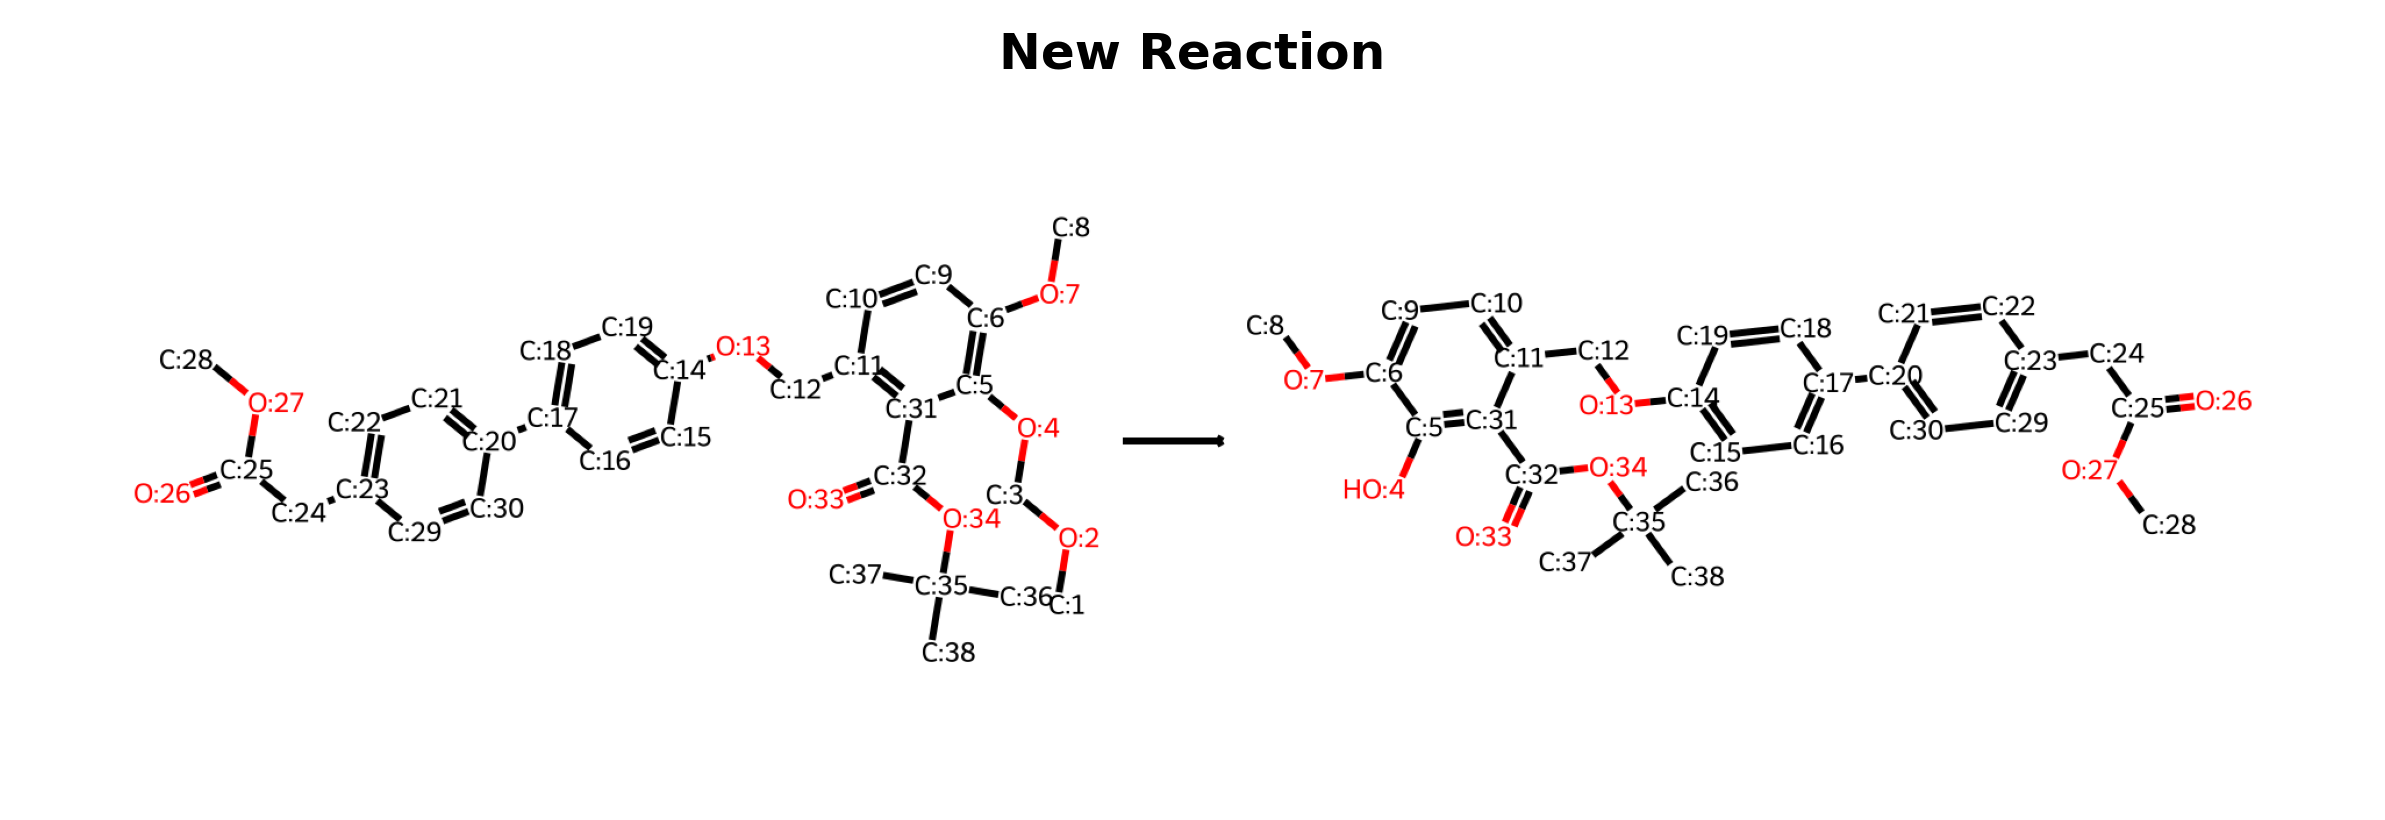

In [81]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(golden[886],'old_reaction', 'old_reaction')

In [3]:
from SynRBL.rsmi_utils import load_database

In [4]:
golden = load_database('../../Data/Validation_set/golden_dataset/MCS/Final_Graph.json.gz')
data = load_database('../../Data/Validation_set/golden_dataset/mcs_based_reactions.json.gz')

In [6]:
r_id = [value['R-id'] for _, value in enumerate(golden)]
bug = [data[key] for key, value in enumerate(data) if value['R-id'] not in r_id]

In [7]:
bug

[{'reactions': '[CH3:1][CH:2]([CH3:3])[CH:4]=[CH:5][CH:6]([CH3:8])[CH3:7].[O:9]=[O:10]>>',
  'id': 'golden_366',
  'reactants': '[CH3:1][CH:2]([CH3:3])[CH:4]=[CH:5][CH:6]([CH3:8])[CH3:7].[O:9]=[O:10]',
  'products': '',
  'R-id': 'USPTO_50K_366',
  'carbon_balance_check': 'products'}]

In [ ]:
'[CH3:1][CH:2]([CH3:3])[CH:4]=[CH:5][CH:6]([CH3:8])[CH3:7].[O:9]=[O:10]>>'

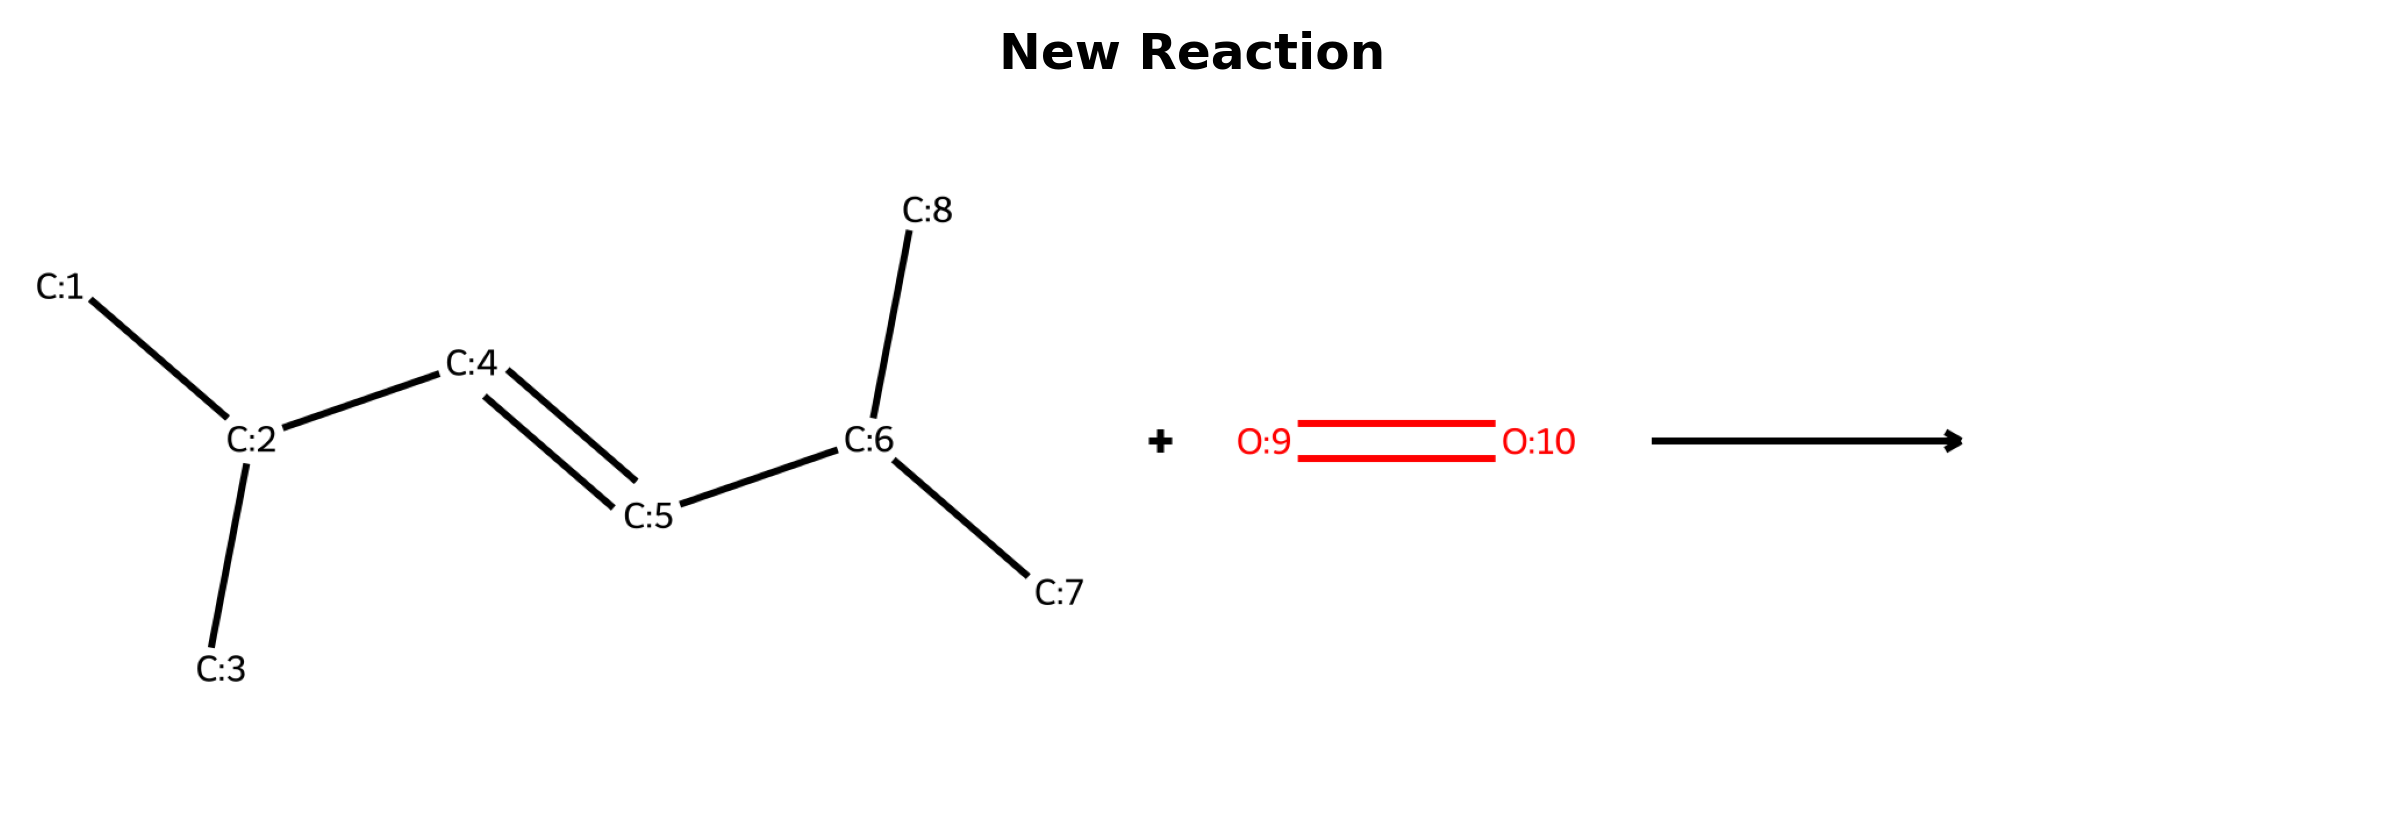

In [10]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(bug[0], 'reactions', 'reactions')